# Time Series Prediction


## Introduction

Predicting time series data is useful for a variety of business applications. Companies forecast time series data in order to forecast sales, manage their supply chains, and more.

LSTMs are commonly used for time series prediction because they are able to learn the underlying patterns of time series data. 

In this exercise, we will use an LSTM to forecast the data from a random timeseries by training it on the timeseries.

## Instructions

You can begin forecasting trends with LSTMs with the following steps:

1. Generate your timeseries data in Numpy
2. Load the data into PyTorch
3. Train your model on the data
4. Run the model to predict the next steps in the time series.

In [1]:
# Imports
# https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn

/var/folders/vg/p2pbdvdn7vz7rb20_j9f8gsc0000gn/T/ipykernel_7099/738719218.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Generate X, Y data

In [135]:
# Create a sinusoidal dataset
X = np.arange(1000)
Y = np.array([np.sin(x/10) + 0.01*x for x in X])
timeseries = np.reshape(Y.astype("float32"), (-1, 1))

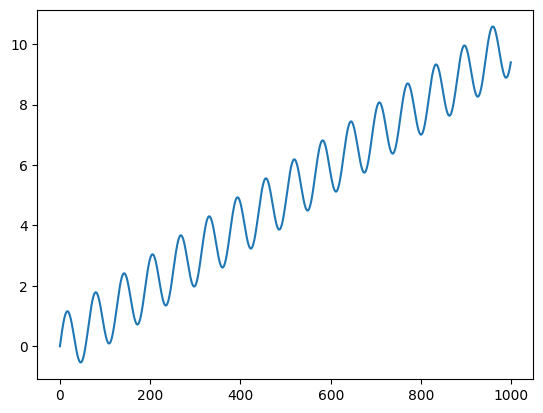

In [136]:
# Plot data
plt.plot(X, Y)

## Load data to Pytorch

In [143]:
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

In [144]:
lookback = 6
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

In [154]:
# Convert to Pandas Dataframe for regression model
df_train_X = pd.DataFrame(X_train.reshape(-1, X_train.shape[1]))
df_train_y = pd.DataFrame(y_train.reshape(-1, y_train.shape[1])).iloc[:,-1:]
df_test_X = pd.DataFrame(X_test.reshape(-1, X_test.shape[1]))
df_test_y = pd.DataFrame(y_test.reshape(-1, y_test.shape[1])).iloc[:,-1:]
df_train_X.head()

,0,1,2,3,4,5
0,0.000000,0.109833,0.218669,0.325520,0.429418,0.529426
1,0.109833,0.218669,0.325520,0.429418,0.529426,0.624642
2,0.218669,0.325520,0.429418,0.529426,0.624642,0.714218
3,0.325520,0.429418,0.529426,0.624642,0.714218,0.797356
4,0.429418,0.529426,0.624642,0.714218,0.797356,0.873327


In [145]:
# Convert to tensors for LSTM model
X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([664, 6, 1]) torch.Size([664, 6, 1])
torch.Size([324, 6, 1]) torch.Size([324, 6, 1])


## Create an LSTM Model

In [146]:
import torch.nn as nn

class TimeSeriesModel(nn.Module):
    def __init__(self):
        super().__init__()
        # The output of nn.LSTM() is a tuple. The first element is the 
        # generated hidden states, one for each time step of the input. 
        # The second element is the LSTM cell’s memory and hidden states, 
        # which is not used here.
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        # Use a fully-connected layer to generate a single regression result
        self.linear = nn.Linear(50, 1) 
    def forward(self, x):
        x, _ = self.lstm(x)
        # extract only the last time step
        # x = x[:, -1, :]
        x = self.linear(x)
        return x

## Train model

In [147]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = TimeSeriesModel()
optimizer = optim.Adam(model.parameters())
# Since its a regression problem we can use MSE as the loss function
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    # TRAINING
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        # Set the gradients to zero before 
        # starting to do backpropragation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # VALIDATION
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 1.7848, test RMSE 4.6112
Epoch 100: train RMSE 0.0389, test RMSE 0.2206
Epoch 200: train RMSE 0.0306, test RMSE 0.1455
Epoch 300: train RMSE 0.0300, test RMSE 0.1295
Epoch 400: train RMSE 0.0310, test RMSE 0.1221
Epoch 500: train RMSE 0.0296, test RMSE 0.1297
Epoch 600: train RMSE 0.0310, test RMSE 0.1456
Epoch 700: train RMSE 0.0319, test RMSE 0.1534
Epoch 800: train RMSE 0.0365, test RMSE 0.1498
Epoch 900: train RMSE 0.0302, test RMSE 0.1440
Epoch 1000: train RMSE 0.0297, test RMSE 0.1436
Epoch 1100: train RMSE 0.0309, test RMSE 0.1557
Epoch 1200: train RMSE 0.0339, test RMSE 0.1320
Epoch 1300: train RMSE 0.0300, test RMSE 0.1411
Epoch 1400: train RMSE 0.0315, test RMSE 0.1593
Epoch 1500: train RMSE 0.0306, test RMSE 0.1648
Epoch 1600: train RMSE 0.0300, test RMSE 0.1632
Epoch 1700: train RMSE 0.0318, test RMSE 0.1734
Epoch 1800: train RMSE 0.0313, test RMSE 0.1630
Epoch 1900: train RMSE 0.0300, test RMSE 0.1734


## Show results

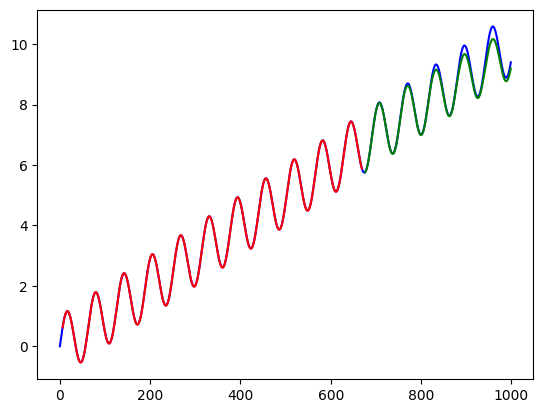

In [148]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

## Compare predictions to linear regression model

In [74]:
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.4/165.4 kB 3.4 MB/s eta 0:00:003.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 1.6 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 813.9 kB/s eta 0:00:00m eta 0:00:010:00:02

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [149]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

In [150]:
reg.fit(df_train_X, df_train_y)

LinearRegression()

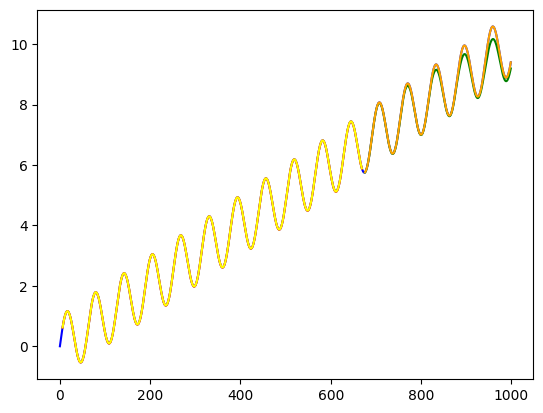

In [156]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

train_plot_reg = np.ones_like(timeseries) * np.nan
y_pred_reg = reg.predict(df_train_X)
train_plot_reg[lookback:train_size] = y_pred_reg

test_plot_reg = np.ones_like(timeseries) * np.nan
y_pred_reg = reg.predict(df_test_X)
test_plot_reg[train_size+lookback:len(timeseries)] = y_pred_reg

# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.plot(train_plot_reg, c="yellow")
plt.plot(test_plot_reg, c="orange")
plt.show()